In [1]:

import pandas as pd
import numpy as np
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from CommonFunc.db_handler import DbHandler
from CommonFunc.fetch_update import FetcherUpdater

#### Update Data and Save to DB

In [11]:
# using absolute db path
db = DbHandler("D:\个人文件\个人发展\Git Projects\crypto-analysis\Data\crypto.db")
fetch_update = FetcherUpdater("D:\个人文件\个人发展\Git Projects\crypto-analysis\Data\crypto.db")

crypto = 'SOL'
crypto_lower = 'sol'

update_df = fetch_update.add_price_data(crypto=f'{crypto}', table=f'{crypto_lower}_hourly')
print(update_df)

Data is already up-to-date.
None


In [12]:
# save to db if there's updated data
if not update_df.empty:
    db.save_to_db(update_df, f'{crypto_lower}_hourly')
else:
    print('Data is up-to-date')

AttributeError: 'NoneType' object has no attribute 'empty'

#### Getting Data and Process Date Columns

In [ ]:
# query eth price data
query = f"SELECT * FROM {crypto_lower}_hourly order by time" # contains eth hourly data from 2021
df = db.read_from_db(query)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35715 entries, 0 to 35714
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        35715 non-null  int64  
 1   utc_dt      35715 non-null  object 
 2   nyc_dt      35715 non-null  object 
 3   high        35715 non-null  float64
 4   low         35715 non-null  float64
 5   open        35715 non-null  float64
 6   close       35715 non-null  float64
 7   volumefrom  35715 non-null  float64
 8   volumeto    35715 non-null  float64
 9   avg         35715 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.7+ MB
None


In [9]:
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

df['year'] = df['utc_dt'].dt.year
df['month'] = df['utc_dt'].dt.month
df['day'] = df['utc_dt'].dt.day
df['weekday'] = df['utc_dt'].dt.weekday # Monday=0, Sunday=6
df['hour'] = df['utc_dt'].dt.hour

#### Visualizing Pricing Trend

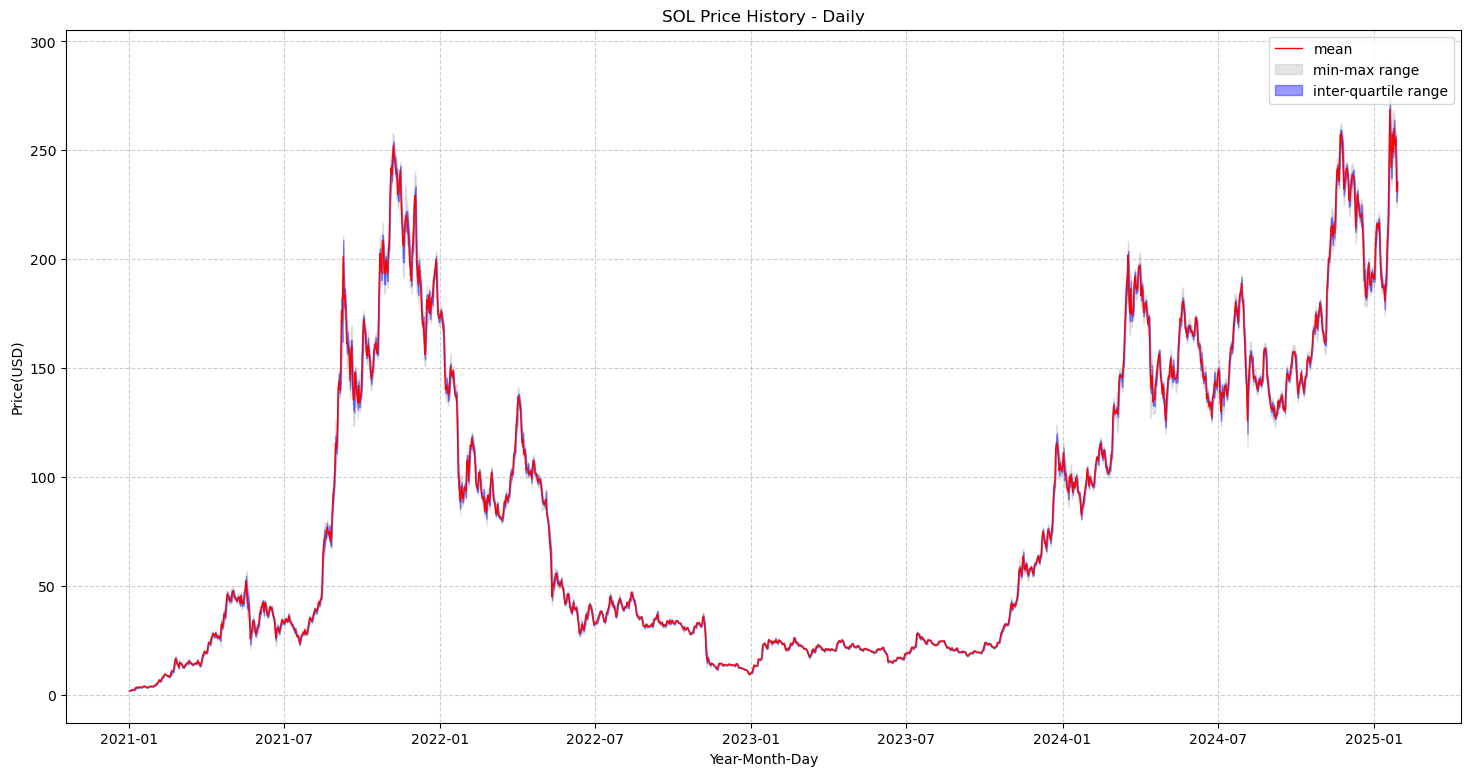

In [13]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month/day
res = df.groupby(['year','month','day'])['avg'].describe().reset_index()
res['ymd'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-' + res['day'].astype(str))

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ymd'],res['mean'],'r-',label='mean',linewidth=1)
# range
plt.fill_between(res['ymd'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ymd'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title(f'{crypto} Price History - Daily')
plt.xlabel('Year-Month-Day')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

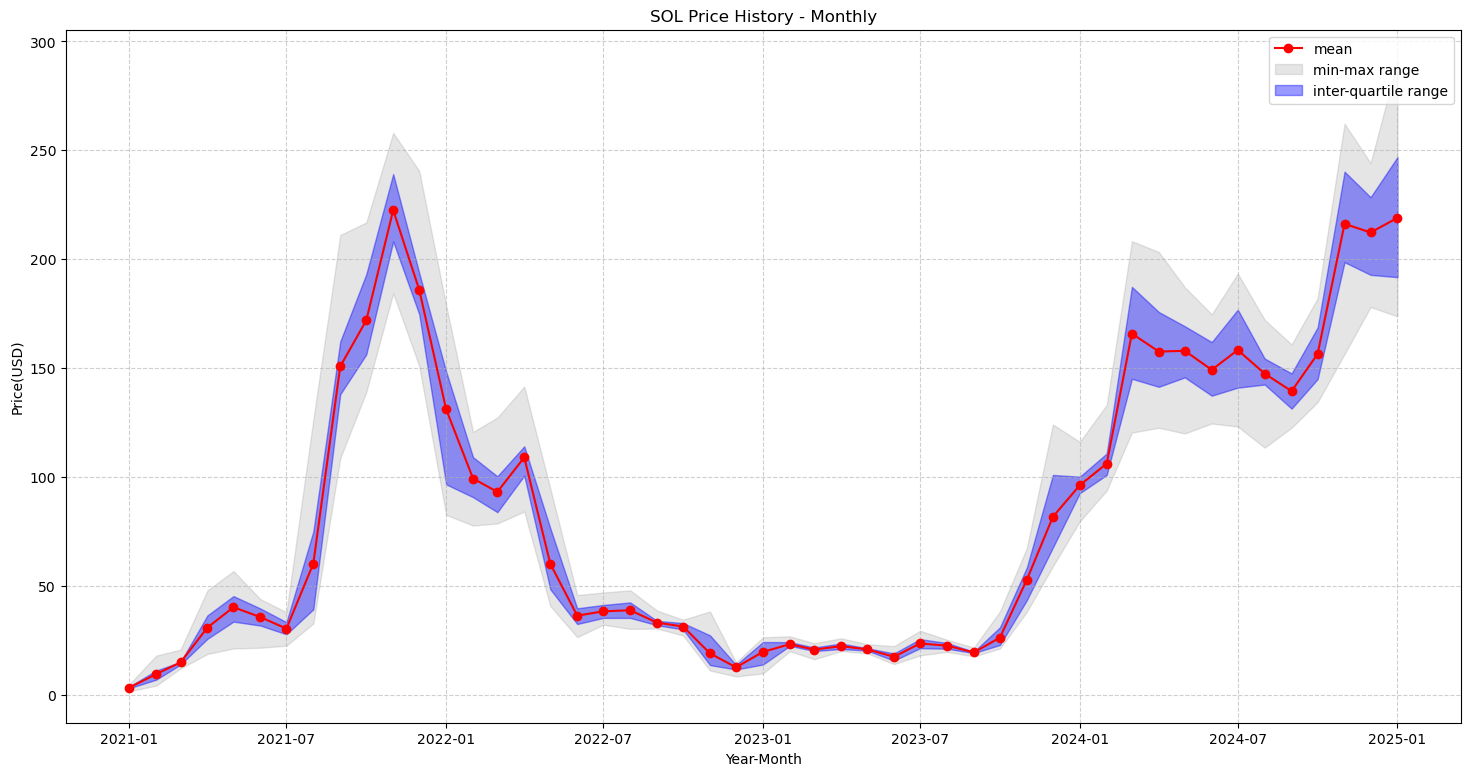

In [14]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month
res = df.groupby(['year','month'])['avg'].describe().reset_index()
res['ym'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-01')

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ym'],res['mean'],'ro-',label='mean')
# range
plt.fill_between(res['ym'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ym'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title(f'{crypto} Price History - Monthly')
plt.xlabel('Year-Month')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

#### A Glimpse at Price Fluctuation within a Month

           ym        std    std_pct
0  2021-01-01   0.716099  22.220754
1  2021-02-01   3.236790  34.376395
2  2021-03-01   1.789315  12.099341
3  2021-04-01   8.000699  25.974165
4  2021-05-01   7.492848  18.673870
5  2021-06-01   4.613905  12.962574
6  2021-07-01   3.345379  11.045155
7  2021-08-01  22.870370  38.001078
8  2021-09-01  20.160021  13.374369
9  2021-10-01  20.516907  11.936154
10 2021-11-01  17.757008   7.980493
11 2021-12-01  17.305736   9.307270
12 2022-01-01  28.396126  21.670312
13 2022-02-01  10.291336  10.369098
14 2022-03-01  11.056710  11.877090
15 2022-04-01  12.767505  11.718995
16 2022-05-01  16.357275  27.233300
17 2022-06-01   4.391845  12.116376
18 2022-07-01   3.752281   9.812050
19 2022-08-01   4.531198  11.694672
20 2022-09-01   1.561218   4.723975
21 2022-10-01   1.851066   5.921806
22 2022-11-01   8.279898  43.788247
23 2022-12-01   1.410093  11.260220
24 2023-01-01   5.108490  26.044982
25 2023-02-01   1.454467   6.281559
26 2023-03-01   1.413609   6

<Figure size 1800x900 with 0 Axes>

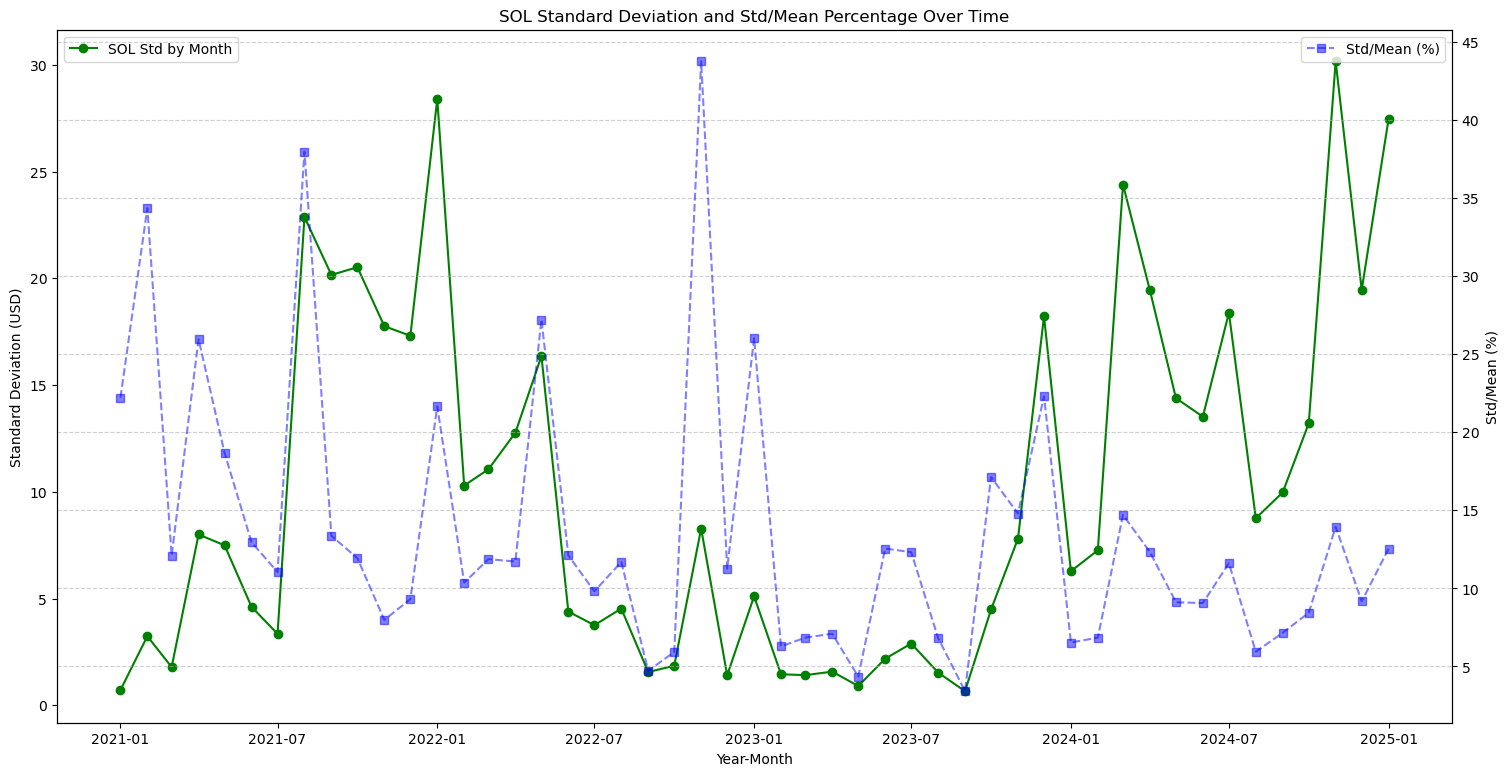

In [15]:
# plot std
#-----------by year/month
res = df.groupby(['year','month'])['avg'].describe().reset_index()
res['ym'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-01')

plt.figure(figsize=(18,9))

# std/mean
res['std_pct'] = res['std']*100/res['mean']
print(res[['ym','std','std_pct']])

# plot with 2 axis
fig, ax1 = plt.subplots(figsize=(18,9))

ax1.plot(res['ym'],res['std'],'go-',label=f'{crypto} Std by Month')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Standard Deviation (USD)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(res['ym'],res['std_pct'],'bs--',label='Std/Mean (%)',alpha=0.5)
ax2.set_ylabel('Std/Mean (%)')
ax2.legend(loc='upper right')

plt.title(f'{crypto} Standard Deviation and Std/Mean Percentage Over Time')
plt.grid(linestyle='--', alpha=0.6)

#### Hourly Data Examination

Same as BTC, the ratio between Open/Close Range and High/Low Range is pretty much evenly distributed (<0.8) with a slight peak around 0.5, which means the open/close prices indicate very little about high/low prices.

count    9435.000000
mean        0.008882
std         0.536947
min        -1.000000
25%        -0.460547
50%         0.017182
75%         0.480149
max         1.022222
Name: ratio, dtype: float64


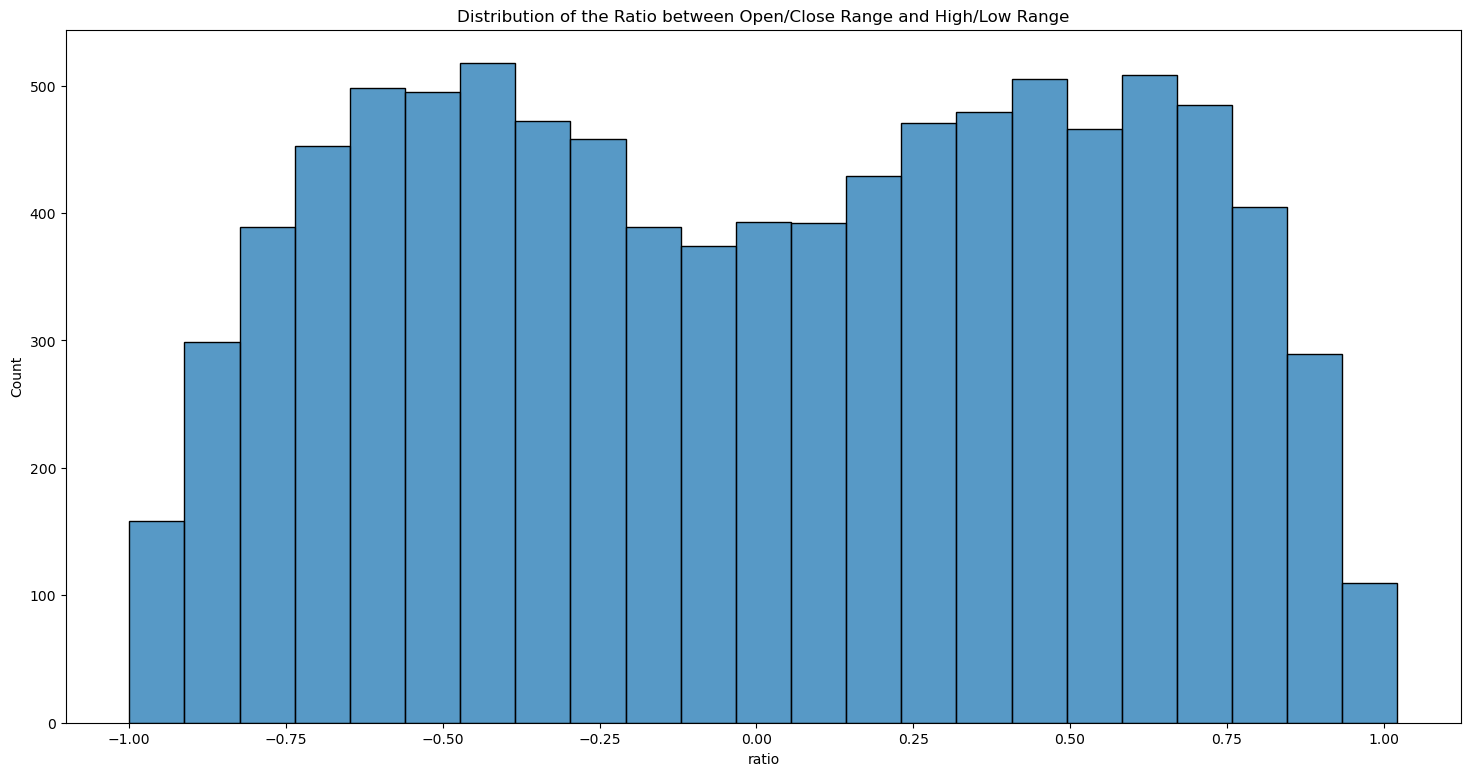

In [16]:
# hourly openclose/minmax ratio distribution
df['minmax_range'] = df['high'] - df['low']
df['openclose_range'] = df['close'] - df['open']
df['ratio'] = df['openclose_range']/df['minmax_range']

df24 = df[df['year']>=2024] 

print(df24['ratio'].describe())

plt.figure(figsize=(18,9))
sns.histplot(x=df24['ratio'])
plt.title('Distribution of the Ratio between Open/Close Range and High/Low Range')
plt.show()

ETH price fluctuation within an hour can be horrible - keep below numbers in mind when dealing contract
- ETH price can rise/drop more than 15% of its average trading price during an hour!
- Generally (in 95% of cases), ETH price change within an hour is less than 70, or roughly 2.2%

0.00     0.24
0.05     0.67
0.10     0.81
0.15     0.94
0.20     1.04
0.25     1.15
0.30     1.25
0.35     1.35
0.40     1.47
0.45     1.58
0.50     1.70
0.55     1.85
0.60     2.00
0.65     2.17
0.70     2.38
0.75     2.65
0.80     2.97
0.85     3.39
0.90     4.04
0.95     5.34
1.00    27.57
Name: minmax_range, dtype: float64


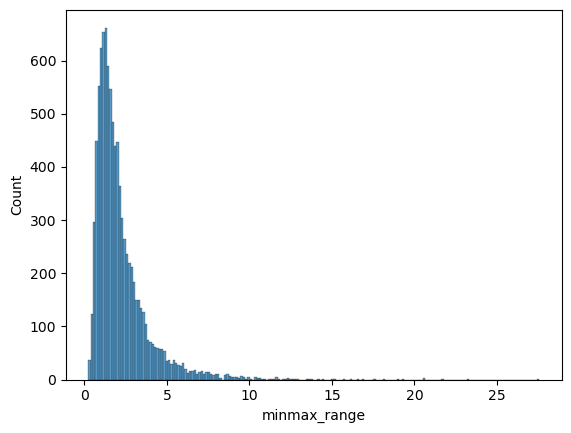

In [17]:
# minmax range distribution
print(df24['minmax_range'].quantile([x/20 for x in range(21)]))
sns.histplot(x=df24['minmax_range'])
plt.show()

0.00    0.001917
0.05    0.004764
0.10    0.005675
0.15    0.006420
0.20    0.007064
0.25    0.007682
0.30    0.008309
0.35    0.008952
0.40    0.009586
0.45    0.010285
0.50    0.011016
0.55    0.011804
0.60    0.012648
0.65    0.013702
0.70    0.014933
0.75    0.016502
0.80    0.018362
0.85    0.020844
0.90    0.024335
0.95    0.031001
1.00    0.186080
dtype: float64


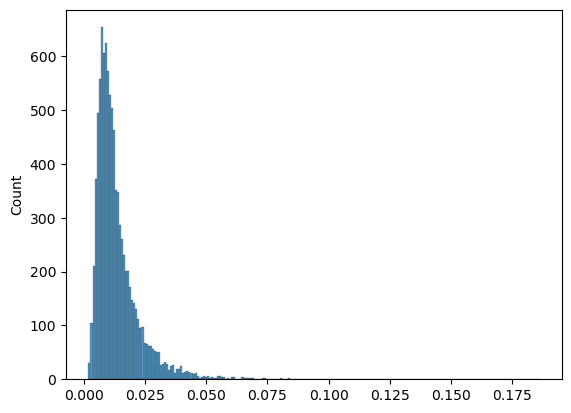

In [18]:
print((df24['minmax_range']/df24['open']).quantile([x/20 for x in range(21)]))
sns.histplot(x=df24['minmax_range']/df['open'])
plt.show()

There is high correlation (0.46) between the price change and the number of ETH traded - volume traded typically means higher price change.

In [19]:
# ABS trade volume change vs. price change after 2024
df24['abs_price_change'] = np.abs(df24['avg'] - df24['avg'].shift(1)) / df24['avg'].shift(1)
df24['abs_volume_change'] = np.abs(df24['volumefrom'] - df24['volumefrom'].shift(1))/ df24['avg'].shift(1)

# correlation between price change and volume traded
print(df24['abs_price_change'].corr(df24['abs_volume_change'])) # from hour to hour
print(np.abs(df24['openclose_range']).corr(df24['volumefrom'])) # within an hour

0.4865296015356498
0.5690541089408392


C:\Users\elisa\AppData\Local\Temp\ipykernel_56208\4293339652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['abs_price_change'] = np.abs(df24['avg'] - df24['avg'].shift(1)) / df24['avg'].shift(1)
C:\Users\elisa\AppData\Local\Temp\ipykernel_56208\4293339652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['abs_volume_change'] = np.abs(df24['volumefrom'] - df24['volumefrom'].shift(1))/ df24['avg'].shift(1)


In [20]:
# calculate price change within an hour
df24['price_pct_change'] = df24['openclose_range']*100/df24['open']
# print(df24['price_pct_change'].describe())

# Define surges and drops based on thresholds
price_surge_threshold = 0.05  
price_drop_threshold = -0.05 

df24['price_surge'] = df24['price_pct_change'] > price_surge_threshold
df24['price_drop'] = df24['price_pct_change'] < price_drop_threshold

C:\Users\elisa\AppData\Local\Temp\ipykernel_56208\2470375799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['price_pct_change'] = df24['openclose_range']*100/df24['open']
C:\Users\elisa\AppData\Local\Temp\ipykernel_56208\2470375799.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['price_surge'] = df24['price_pct_change'] > price_surge_threshold
C:\Users\elisa\AppData\Local\Temp\ipykernel_56208\2470375799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [21]:
# Define a helper function to calculate lasting periods
def calculate_periods(series):
    periods = []
    current_length = 0
    for value in series:
        if value:
            current_length += 1
        else:
            if current_length > 0:
                periods.append(current_length)
            current_length = 0
    if current_length > 0:
        periods.append(current_length)
    return periods

# Calculate lasting periods for price surges and drops
price_surge_periods = calculate_periods(df24['price_surge'])
price_drop_periods = calculate_periods(df24['price_drop'])

print(pd.Series(price_surge_periods).value_counts())
print(pd.Series(price_drop_periods).value_counts())

print("Price Surge Periods Statistics:", np.mean(price_surge_periods), np.std(price_surge_periods))
print("Price Drop Periods Statistics:", np.mean(price_drop_periods), np.std(price_drop_periods))

1    1349
2     638
3     285
4     127
5      50
6      30
7      12
8       3
9       1
dtype: int64
1     1330
2      655
3      296
4      115
5       40
6       20
8        6
7        4
9        1
10       1
dtype: int64
Price Surge Periods Statistics: 1.817635270541082 1.1752327272352514
Price Drop Periods Statistics: 1.7840356564019448 1.1171078303930106
